**CLASIFICACION MULTICLASE**

In [133]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt



Carga y exploración de datos

In [134]:
# Carga los datos desde un archivo CSV
data = pd.read_csv('datasets/train-Dig-MNIST.csv')

# Visualiza las primeras filas del conjunto de datos
print(data.head())



   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      0       0       0       0       0       0       0       0       0   
1      1       0       0       0       0       0       0       0       0   
2      2       0       0       0       0       0       0       0       0   
3      3       0       0       0       0       0       0       0       0   
4      4       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

Preprocesamiento de datos

Realiza cualquier preprocesamiento necesario, como la eliminación de valores nulos, la codificación de variables categóricas y la normalización de datos.

In [135]:
# Divide el conjunto de datos en características (X) y variable objetivo (y)
X = data.iloc[:, 1:]
y = data.iloc[:, 0] 

# establecer el dígito cero en 0, en lugar del 10 asignado a este conjunto de datos
y[y == 10] = 0


Visualización de los datos

Se comenzará visualizando un subconjunto del conjunto de entrenamiento. Se selecciona al azar, 100 filas de `X` y pasa esas filas a la función` displayData`. Esta función asigna cada fila a una imagen en escala de grises de 20 píxeles por 20 píxeles y muestra las imágenes juntas.

In [136]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values  # Convierte el DataFrame a una matriz NumPy

    m, n = X.shape

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n // example_width

    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_height, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


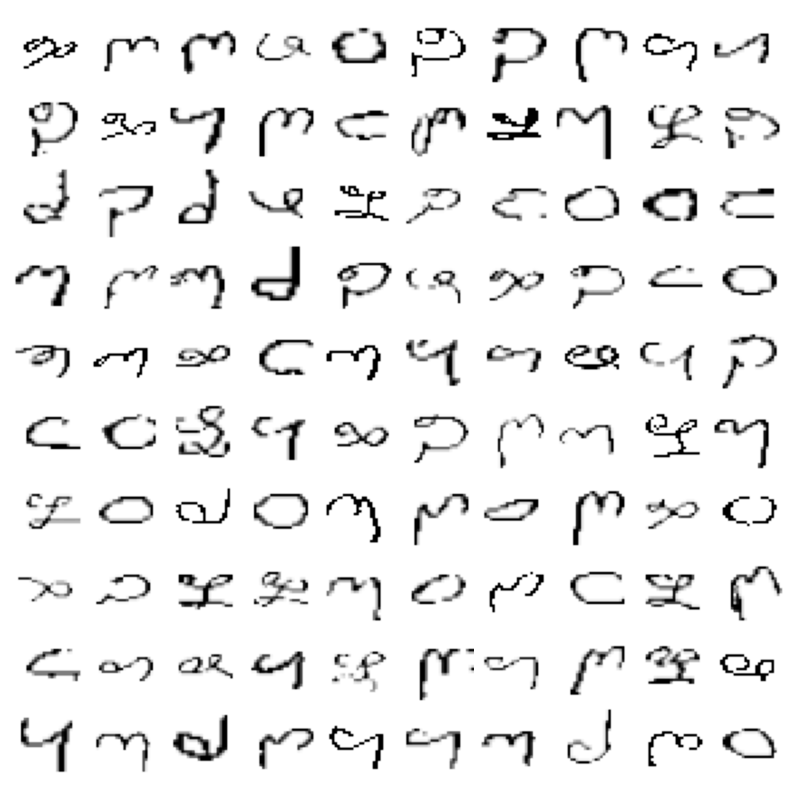

In [137]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(len(X), 100, replace=False)
sel = X.iloc[rand_indices, :]

displayData(sel)

División del conjunto de datos

Divide el conjunto de datos en conjuntos de entrenamiento y prueba.

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Conversion de datos de Numpy a tensores de Pytorch** para asegurar la compatibilidad con las operaciones y modelos de PyTorch, permitiendo el cálculo de gradientes durante el entrenamiento, lo que es esencial para el aprendizaje automático, y para aprovechar eficientemente la aceleración de hardware, como las GPUs, mientras se mantiene la flexibilidad de trabajar con datos en NumPy cuando sea necesario.

In [139]:
# Normaliza las características (opcional pero generalmente recomendado)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Definición del modelo de regresión

Definir el modelo de regresion logistica utilizando PyTorch.

In [148]:
class ClasificadorMulticlase(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClasificadorMulticlase, self).__init__()
        
        # Capa de entrada (mantén el mismo número de entradas)
        self.fc1 = nn.Linear(input_size, 128)  # Agrega una capa oculta con 128 neuronas
        self.relu1 = nn.ReLU()
        
        # Nuevas capas ocultas (puedes agregar más según sea necesario)
        self.fc2 = nn.Linear(128, 64)  # Agrega otra capa oculta con 64 neuronas
        self.relu2 = nn.ReLU()
        
        # Capa de salida (mantén el mismo número de salidas)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)  # Pasa a través de la segunda capa oculta
        x = self.relu2(x)
        
        x = self.fc3(x)  # Capa de salida
        return x

input_size = 784
num_classes = 10
model = ClasificadorMulticlase(input_size, num_classes)


Entrenamiento del modelo

Entrena del modelo con descenso por el gradiente

In [149]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()  # Para clasificación multiclase
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Entrenamiento del modelo
num_epochs = 1000
train_losses = []

for epoch in range(num_epochs):
    inputs = torch.Tensor(X_train).float()
    targets = torch.LongTensor(y_train.values)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())


Grafica de la convergencia del costo durante el entrenamiento, se registra la pérdida (loss) en cada época y luego se traza esta información.

Evaluación del modelo

Evalúa el rendimiento del modelo en el conjunto de prueba.

In [152]:
# Cambiar al modo de evaluación
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    test_inputs = torch.Tensor(X_test).float()
    predictions = model(test_inputs)
    predicted_classes = torch.argmax(predictions, dim=1)
    y_true.extend(y_test.values)
    y_pred.extend(predicted_classes.numpy())

accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

print(f'Exactitud: {accuracy:.4f}')
print('Matriz de Confusión:')
print(conf_matrix)
print('Reporte de Clasificación:')
print(class_report)


Exactitud: 0.9412
Matriz de Confusión:
[[1099   53    1    9    1    0    2    3    8    1]
 [   9 1181    1   18    2    3    1    0    0    3]
 [  11    0 1205    0    0    5    1    0    1    1]
 [  13    1    4 1093   12   10    4   47    0    0]
 [   3    1    0    3 1185   18    1    5    2    3]
 [   0    7   10    6   39 1121    0    2    2    1]
 [   0    0    0    7    2    0 1107   50    2    1]
 [   8    0    0   50   17    0  109 1035    0    0]
 [  21    4    0    2    9    4    1    0 1120   25]
 [   2    0    0    2   20    1    9   16   16 1148]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1177
           1       0.95      0.97      0.96      1218
           2       0.99      0.98      0.99      1224
           3       0.92      0.92      0.92      1184
           4       0.92      0.97      0.94      1221
           5       0.96      0.94      0.95      1188
           6       0.90  

Calcular el porcentaje de error utilizando un ejemplo de predicción real a partir de tus datos de prueba

In [153]:
# Supongamos que ya tienes un modelo entrenado llamado 'model' y un conjunto de prueba 'X_test' y 'y_test'.
y_test = y_test.reset_index(drop=True)
# Paso 1: Selecciona un ejemplo específico del conjunto de prueba (por ejemplo, el primer ejemplo)
index = 2
example_input = X_test[index]
example_label = y_test[index]

# Paso 2: Realiza una predicción con el modelo
model.eval()
with torch.no_grad():
    example_input = torch.Tensor(example_input).float()
    predicted_output = model(example_input)

# Paso 3: Calcula el error absoluto
error = abs(int(predicted_output[0]) - example_label)

# Paso 4: Calcula el porcentaje de error
num_classes = 10  # Número de clases en MNIST (0-9 dígitos)
error_percentage = (error / num_classes) * 100

print(f'Ejemplo de prueba: Etiqueta real = {example_label}, Predicción = {int(predicted_output[0])}')
print(f'Error absoluto = {error}')
print(f'Porcentaje de error = {error_percentage:.2f}%')



Ejemplo de prueba: Etiqueta real = 1, Predicción = 2
Error absoluto = 1
Porcentaje de error = 10.00%


In [154]:
# Desactivar el modo de evaluación
model.eval()

# Calcular las predicciones en el conjunto de entrenamiento
with torch.no_grad():
    train_inputs = torch.Tensor(X_train).float()
    train_predictions = model(train_inputs)
    train_predicted_classes = torch.argmax(train_predictions, dim=1)

# Comparar las predicciones con las etiquetas verdaderas del conjunto de entrenamiento
y_train_tensor = torch.LongTensor(y_train.values)
train_accuracy = accuracy_score(y_train_tensor, train_predicted_classes)

print(f'Precisión de entrenamiento: {train_accuracy:.4f}')
print(f'Precisión de entrenamiento: {train_accuracy * 100:.2f}%')


Precisión de entrenamiento: 0.9396
Precisión de entrenamiento: 93.96%
